In [129]:
# General packages
import os 
import datetime as dt
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import glob

# Text Processing
import nltk
from nltk import word_tokenize, TweetTokenizer, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
from sklearn.decomposition import LatentDirichletAllocation

# Topic Modelling
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim

# Plots
import matplotlib.pyplot as plt

import pickle
from utils import *

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Preprocessing

## Converting json files into csv files

In [ ]:
path = '/Users/chenjianyu/Desktop/Y2S2/IS450 Text Mining and Language Processing/Project/AmazonReviews/'

product_files = [filename for filename in os.listdir(path) if filename != '.DS_Store']

for product in product_files:
    product_df = pd.DataFrame()

    product_file_path = path + product
    for filename in glob.glob(os.path.join(product_file_path, '*.json')):
        with open(os.path.join(os.getcwd(), filename), 'r') as f:
            data = json.load(f) #loading json data file
            df = json_normalize(data) # normalizing json data to flatten the data so that it can be converted to Pandas dataframe
            df1 = pd.DataFrame(df['Reviews'][0]) # extracting the reviews and store in a temp df
            if len(df) != 0: # check if df is empty
                # empty df means that there was no text review by that user, and we want to remove such data as it is not meaningful to us
                df1['Product_ID'] = df.iloc[0]['ProductInfo.ProductID']
                df1['Product_Name'] = df.iloc[0]['ProductInfo.Name']
                df1['Product_Features'] = df.iloc[0]['ProductInfo.Features']
                df1['Product_Price'] = df.iloc[0]['ProductInfo.Price']
                
                product_df = product_df.append(df1, ignore_index = True) # append into the product df created earlier if there is a review
    
    # drop records with no reviews
    product_df.dropna(subset = ['Content', 'Product_Name'], inplace = True)

    # exporting processed data into csv file
    os.mkdir('Cleaned Data') # creating a new directory to store the data
    product_df.to_csv(f'Cleaned Data/{product}_reviews.csv') 

# Exploratory Data Analysis

## Creating a bar chart for number of reviews against each product category

In [14]:
file_path = './Data'
csv_files = [filename for filename in os.listdir(file_path) if filename.endswith('reviews.csv')]

num_reviews = {
    'product': [],
    'reviews': []
}

for filename in csv_files:
    df = pd.read_csv(f'{file_path}/{filename}')
    product_name = filename[:-4] # remove '.csv' at the end of each csv file
    num_reviews['product'].append(product_name)
    num_reviews['reviews'].append(len(df))

/Users/chenjianyu/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0,2,2])
product = num_reviews['product']
reviews_num = num_reviews['reviews']
ax.bar(product, reviews_num)
plt.title("Bar chart of number of reviews for each product category", fontsize = 20)
plt.xlabel("Products", fontsize = 15)
plt.ylabel("Number of reviews",fontsize = 15)
for i in range(len(num_reviews['product'])):
    plt.text(x=i-0.20, y = num_reviews['reviews'][i]+5000 , s=f"{num_reviews['reviews'][i]}" , fontdict=dict(fontsize=15))
# ax.set_xticks()
plt.tight_layout()
plt.show()

## Check for NA/empty reviews content

In [15]:
for filename in csv_files:
    df = pd.read_csv(f'{file_path}/{filename}')
    print(' '* 10 + filename[:-4] + ' '* 10)
    print('-'*50)
    print(df.info())
    print()

          laptops_reviews          
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40762 entries, 0 to 40761
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         40762 non-null  int64  
 1   Title              40761 non-null  object 
 2   Author             40693 non-null  object 
 3   ReviewID           40762 non-null  object 
 4   Overall            40762 non-null  float64
 5   Content            40744 non-null  object 
 6   Date               40760 non-null  object 
 7   Product_ProductID  40762 non-null  object 
 8   Product_Name       20670 non-null  object 
 9   Product_Features   20554 non-null  object 
 10  Product_Price      19377 non-null  object 
 11  Product_ImgURL     20647 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 3.7+ MB
None

          video_surveillance_reviews          
----------------

## Check for spam/duplicate comments

In [16]:
for filename in csv_files:
    df = pd.read_csv(f'{file_path}/{filename}')
    print(f"Total comments in {filename[:-12]} category is: {len(df['Content'])}")
    print(f"Unique comments in {filename[:-12]} category is: {len(df['Content'].unique())}")
    print()

Total comments in laptops category is: 40762
Unique comments in laptops category is: 36472

Total comments in video_surveillance category is: 59334
Unique comments in video_surveillance category is: 44468

Total comments in cameras category is: 472542
Unique comments in cameras category is: 220261

/Users/chenjianyu/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
Total comments in tablets category is: 124470
Unique comments in tablets category is: 65111

Total comments in mobilephone category is: 186016
Unique comments in mobilephone category is: 149984

Total comments in TVs category is: 233402
Unique comments in TVs category is: 114488



Contains duplicates, go to excel to check in details

# Data Cleaning 
<br>

### - Merging standardized Product ID to every products' reviews dataframe
- For a product base model, there may be several different product names and product ID. Hence, manual work was put in to standardize the Product IDs for all product names which are actually referring to the same base model. 

### - Remove NA rows
### - Remove Spam/Duplicates rows

In [73]:
file_path = './Data'
prod_IDs_path = './Data/ProductIDs/'
data_files = [filename for filename in os.listdir(file_path) if filename.endswith('reviews.csv')]
data_files.sort()
prod_IDs_files = [filename for filename in os.listdir(prod_IDs_path) if filename.endswith('.csv')]
prod_IDs_files.sort()
print(data_files)
print(prod_IDs_files)

['TVs_reviews.csv', 'cameras_reviews.csv', 'laptops_reviews.csv', 'mobilephone_reviews.csv', 'tablets_reviews.csv', 'video_surveillance_reviews.csv']
['TVs_products.csv', 'cameras_products.csv', 'laptops_products.csv', 'mobilephone_products.csv', 'tablets_products.csv', 'video_surveillance_products.csv']
/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
for i in range(len(data_files)):
    reviews = pd.read_csv(f'{file_path}/{data_files[i]}', index_col=0)
    products = pd.read_csv(f'{prod_IDs_path}/{prod_IDs_files[i]}', index_col=0).reset_index()
    products.drop('Counts', axis=1, inplace=True)
    products.rename(columns={'Product': 'Product_Name'}, inplace=True)

    # merging the standardized product IDs to reviews dataframs
    merged = pd.merge(reviews, products, how='left', on=['Product_Name'])
    merged.drop(['Product_ProductID', 'Product_ImgURL', ], axis=1, inplace=True) # drop original product ID column and product image URL (not meaningful in our analysis)
    print(data_files[i][:-12])
    print('-'*10)
    print(f'Before cleaning: {len(merged)}')

    # drop rows if there is NA is either Product_Name/Review Content columns
    merged.dropna(subset=['Product_Name'], inplace=True)
    merged.dropna(subset=['Content'], inplace=True)

    # drop duplicates/spam 
    merged.drop_duplicates(subset=['Author', 'ReviewID', 'Date', 'Content', 'ProductID'], inplace=True)
    merged.drop_duplicates(subset=['Date', 'Content', 'ProductID'], inplace=True)
    print(f'After cleaning: {len(merged)}')
    print()

    merged.to_csv(f'{file_path}/Cleaned Data/{data_files[i]}')

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
TVs
----------
Before cleaning: 257996
After cleaning: 217823

cameras
----------
Before cleaning: 484159
After cleaning: 224942

laptops
----------
Before cleaning: 40821
After cleaning: 19942

mobilephone
----------
Before cleaning: 202280
After cleaning: 146131

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
tablets
----------
Before cleaning: 140785
After cleaning: 45275

video_surveillance
------

## Creating a bar chart for number of reviews against each product category

In [ ]:
file_path = './Cleaned Data/Data'
csv_files = [filename for filename in os.listdir(file_path) if filename.endswith('reviews.csv')]

num_reviews = {
    'product': [],
    'reviews': []
}

for filename in csv_files:
    df = pd.read_csv(f'{file_path}/{filename}')
    product_name = filename[:-4] # remove '.csv' at the end of each csv file
    num_reviews['product'].append(product_name)
    num_reviews['reviews'].append(len(df))

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0,2,2])
product = num_reviews['product']
reviews_num = num_reviews['reviews']
ax.bar(product, reviews_num)
plt.title("Bar chart of number of reviews for each product category", fontsize = 20)
plt.xlabel("Products", fontsize = 15)
plt.ylabel("Number of reviews",fontsize = 15)
for i in range(len(num_reviews['product'])):
    plt.text(x=i-0.20, y = num_reviews['reviews'][i]+5000 , s=f"{num_reviews['reviews'][i]}" , fontdict=dict(fontsize=15))
# ax.set_xticks()
plt.tight_layout()
plt.show()

# Sentiment Analysis

In [117]:
def sent_tokenize_to_df(df):
    sentences_dict = {'Sentences': [], 'Product Name': []}

    for i, row in df.iterrows():
        sentences = sent_tokenize(df['Content'].iloc[i])
        for sent in sentences:
            sentences_dict['Sentences'].append(sent)
            sentences_dict['Product Name'].append(df['Product_Name'].iloc[i])

    final_df = pd.DataFrame(sentences_dict)
    # final_df.drop_duplicates(subset=['Sentences'], inplace=True)
    final_df.reset_index(inplace=True)
    return final_df

def vader_compound_score(x):
    vader_analyser = SentimentIntensityAnalyzer()
    score = vader_analyser.polarity_scores(x)
    return score['compound']

def vader_sentiment(df):
    df['Vader_compound_score'] = df['Sentences'].apply(lambda x: vader_compound_score(x))
    return df

def textblob_sentiment(df):
    df['tb_polarity'] = df['Sentences'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['tb_subjectivity'] = df['Sentences'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

def emotions(df):
    emotions_clf = pickle.load(open('tfidf_svm.sav', 'rb'))
    df['emotion'] = df['Sentences'].apply(lambda x: emotions_clf.predict([x]))
    return df

def get_top_positive_reviews(category, pid, n):
    df = pd.read_csv(f'./Data/Cleaned Data/{category}_reviews.csv', index_col=0)
    df = df[df['ProductID'] == pid].reset_index()
    sent_df = sent_tokenize_to_df(df)

    sent_df = vader_sentiment(sent_df)
    sent_df = textblob_sentiment(sent_df)
    sent_df = emotions(sent_df)
    sent_df['final_sentiment'] = sent_df['Vader_compound_score'] + sent_df['tb_polarity']

    reviews = sent_df.sort_values(by='final_sentiment', ascending=False)['Sentences'].to_list()

    print(f'Product ID: {pid}\n')

    names = list(set(sent_df['Product Name'].to_list()))
    for i in range(len(names)):
        if i == 0:
            print(f'Product Name:\n{names[i]}')
        else:
            print(' '*14 + str(names[i]))
    print()
        
    for i in range(n):
        print(f'Rank {i+1} review:\n{reviews[i]}')
        print()

def get_top_negative_reviews(category, pid, n):
    df = pd.read_csv(f'./Data/Cleaned Data/{category}_reviews.csv', index_col=0)
    df = df[df['ProductID'] == pid].reset_index()
    sent_df = sent_tokenize_to_df(df)

    sent_df = vader_sentiment(sent_df)
    sent_df = textblob_sentiment(sent_df)
    sent_df = emotions(sent_df)
    sent_df['final_sentiment'] = sent_df['Vader_compound_score'] + sent_df['tb_polarity']

    reviews = sent_df.sort_values(by='final_sentiment', ascending=True)['Sentences'].to_list()

    print(f'Product ID: {pid}\n')

    names = list(set(sent_df['Product Name'].to_list()))
    for i in range(len(names)):
        if i == 0:
            print(f'Product Name:\n{names[i]}')
        else:
            print(' '*14 + str(names[i]))
    print()
        
    for i in range(n):
        print(f'Rank {i+1} review:\n{reviews[i]}')
        print()
    
def reviews_by_emotions(category, pid, emotion, n):
    df = pd.read_csv(f'./Data/Cleaned Data/{category}_reviews.csv', index_col=0)
    df = df[df['ProductID'] == pid].reset_index()
    sent_df = sent_tokenize_to_df(df)

    sent_df = vader_sentiment(sent_df)
    sent_df = textblob_sentiment(sent_df)
    sent_df = emotions(sent_df)
    sent_df['final_sentiment'] = sent_df['Vader_compound_score'] + sent_df['tb_polarity']

    reviews_emotion = sent_df[sent_df['emotion'] == emotion].reset_index()

    if emotion == 'joy':
        reviews = reviews_emotion.sort_values(by='final_sentiment', ascending=False)['Sentences'].to_list()
    else:
        reviews = reviews_emotion.sort_values(by='final_sentiment', ascending=True)['Sentences'].to_list()
    

    print(f'Product ID: {pid}\n')

    names = list(set(reviews_emotion['Product Name'].to_list()))
    for i in range(len(names)):
        if i == 0:
            print(f'Product Name:\n{names[i]}')
        else:
            print(' '*14 + str(names[i]))
    print()

    print(f'Review Emotion: {emotion}\n')
        
    for i in range(n):
        print(f'Rank {i+1} review:\n{reviews[i]}')
        print()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
get_top_positive_reviews('laptops', 'B002C74D7A', 10)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Product ID: B002C74D7A

Product Name:
Apple MacBook Pro MC725LL/A 17-Inch Laptop (OLD VERSION)

Rank 1 review:
The battery life is excellent and the screen resolution is excellent

Rank 2 review:
Perfect Screen resolution for content creation work.

Rank 3 review:
I would like to let people know more than just about how great this laptop is, i want to let them also know how great amazon was from start to finish!

Rank 4 review:
THIS THING IS THE BEST LAPTOP I HAVE EVER USED IN MY LIFE!...

Rank 5 review:
Great job Apple!

Rank 6 review:
Excellent Product!

Rank 7 review:
I will add to this review in the coming days 

In [112]:
get_top_negative_reviews('laptops', 'B002C74D7A', 10)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Product ID: B002C74D7A

Product Name:
Apple MacBook Pro MC725LL/A 17-Inch Laptop (OLD VERSION)

Rank 1 review:
Too bad I don't know how to use a Mac or it would be mine instead of my wife's.

Rank 2 review:
Unfortunately unless you order from Apple there's no way to add the high-res display (1680x1050).

Rank 3 review:
For example, I had an Outlook utility that allowed 1 or 2-click email filing when sent or read - I cannot find anything like that for Mac Outlook, and I am very sorry not to have it.

Rank 4 review:
The next day when I contacted the seller - because of a really lame lie he told - I fully understood at

In [118]:
reviews_by_emotions('laptops', 'B002C74D7A', 'joy', 5)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Product ID: B002C74D7A

Product Name:
Apple MacBook Pro MC725LL/A 17-Inch Laptop (OLD VERSION)

Review Emotion: joy

Rank 1 review:
The battery life is excellent and the screen resolution is excellent

Rank 2 review:
Perfect Screen resolution for content creation work.

Rank 3 review:
I would like to let people know more than just about how great this laptop is, i want to let them also know how great amazon was from start to finish!

Rank 4 review:
THIS THING IS THE BEST LAPTOP I HAVE EVER USED IN MY LIFE!...

Rank 5 review:
Great job Apple!



# Topic Modelling

In [138]:
os.environ.update({'MALLET_HOME':r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8'})
mallet_path = r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8/bin/mallet' 

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [136]:
stop_list = nltk.corpus.stopwords.words('english')
stop_list += []

def corpus2docs(df, stop_list):
    docs1 = [TweetTokenizer().tokenize(comment) for comment in df['Sentences']]
    # for i, comment in enumerate(docs1):
    #     tags = nltk.pos_tag(comment)
    #     docs_tags = [tag[0].lower() for tag in tags if tag[1] in pos_tags]
    #     docs1[i] = docs_tags
    docs2 = [[w.lower() for w in doc] for doc in docs1]
    docs3 = [[w for w in doc if len(w) > 2] for doc in docs2]
    docs4 = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in docs3]
    docs5 = [[w for w in doc if w not in stop_list] for doc in docs4]
    return docs5

def docs2vecs(docs, dic):
    vecs = [dic.doc2bow(doc) for doc in docs]
    return vecs

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [137]:
df = pd.read_csv(f'./Data/Cleaned Data/laptops_reviews.csv', index_col=0)
df = df[df['ProductID'] == 'B002C74D7A'].reset_index()
sent_df = sent_tokenize_to_df(df)

docs = corpus2docs(sent_df)
dic = gensim.corpora.Dictionary(docs)
vecs = docs2vecs(docs, dic)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [162]:
model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 15):
    # lda_gensim = gensim.models.ldamodel.LdaModel(corpus=valuable_vecs, id2word=valuable_dic, num_topics=num_topics, random_state=99, iterations=100)
    lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, iterations=500, corpus=vecs, num_topics=num_topics, id2word=dic, random_seed=99)
    coherencemodel = CoherenceModel(model=lda_mallet, texts=docs, dictionary=dic, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_mallet)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
#Topics: 2 Score: 0.5153460927158997
#Topics: 3 Score: 0.550764359071697
#Topics: 4 Score: 0.6004770973011092
#Topics: 5 Score: 0.6136470259313744
#Topics: 6 Score: 0.6339404729620873
#Topics: 7 Score: 0.6662357246298715
#Topics: 8 Score: 0.6553978174311795
#Topics: 9 Score: 0.6777025551898037
#Topics: 10 Score: 0.663097525120305
#Topics: 11 Score: 0.6831871276160012
#Topics: 12 Score: 0.68332542626489
#Topics: 13 Score: 0.7085060603459699
#Topics: 14 Score: 0.721658559164882


/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


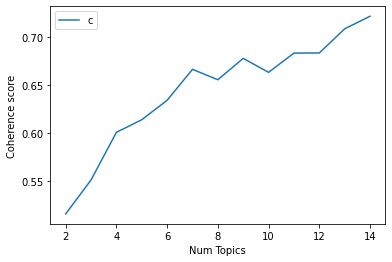

In [143]:
import matplotlib.pyplot as plt

limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [152]:
no_topics= 7#make this 2 to test. 
no_iter=500 #make this 50 to test

lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=vecs, iterations=500, num_topics=no_topics, id2word=dic, random_seed=99, alpha=0.1)
mallet_lda_model= gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

vecTop = lda_mallet.show_topics(num_words=30)
for i in range(0, 7):
    print(vecTop[i])
    print()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(0, '0.036*"mac" + 0.033*"drive" + 0.022*"amazing" + 0.022*"upgrade" + 0.019*"video" + 0.019*"hard" + 0.016*"apple" + 0.016*"products" + 0.016*"performance" + 0.016*"windows" + 0.014*"times" + 0.014*"thing" + 0.014*"ssd" + 0.014*"run" + 0.014*"laptop" + 0.014*"time" + 0.014*"solid" + 0.011*"difference" + 0.011*"system" + 0.011*"machine" + 0.011*"programs" + 0.011*"included" + 0.008*"office" + 0.008*"free" + 0.008*"error" + 0.008*"faster" + 0.008*"speed" + 0.008*"back" + 0.008*"noticeable" + 0.008*"ram"')

(1, '0.040*"mbp" + 0.036*"pro" + 0.032*"display" + 0.029*"macbook" + 0.025*"computers" + 0.025*"apple" + 0.022*"

In [153]:
pyLDAvis.enable_notebook()
visual= pyLDAvis.gensim.prepare(mallet_lda_model, vecs, dic)
pyLDAvis.save_html(visual, f"test_viz.html")

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_t

In [155]:
def format_topics_sentences(ldamodel, corpus, data, ori_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    ori_text = ori_data['Sentences']
    sent_topics_df = pd.concat([sent_topics_df, contents, ori_text], axis=1)
    df_dominant_topic = sent_topics_df.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tokenized Text', 'Original Text']

    return df_dominant_topic

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [156]:
#df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[1], corpus=sg_vecs, data=sg_docs)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_mallet, corpus=vecs, data=docs, ori_data=sent_df)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tokenized Text', 'Original Text']

# Show
df_dominant_topic.head()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tokenized Text,Original Text
0,0,3.0,0.5234,"great, amazon, core, upgraded, laptop, apple, ...","[upgraded, model, early, quad, core, macbook, ...",I upgraded to this model (early 2011 Quad Core...
1,1,6.0,0.9859,"screen, computer, battery, resolution, machine...","[excellent, laptops, remarkably, similar, feat...",Both have been excellent laptops and have rema...
2,2,4.0,0.8521,"mbp, graphics, processor, ghz, card, cores, me...","[however, makes, difference, pure, raw, proces...","However, what makes the difference here is pur..."
3,3,2.0,0.4617,"amazon, mac, system, find, things, application...","[applications, must, written, specific, way, t...",Applications must be written in a specific way...
4,4,4.0,0.9832,"mbp, graphics, processor, ghz, card, cores, me...","[cores, underutilized, processing, speed, use,...",If some of the cores are underutilized then th...


In [160]:
df_dominant_topic.to_csv('test.csv')

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
df = pd.read_csv('./Data/Cleaned Data/laptops_reviews.csv')

start = timeit.default_timer()
df = get_vader_sentiment(df)
stop = timeit.default_timer()
print('Time: ', stop - start) 
# print('vader complete')
# df = get_textblob_sentiment(df)
# print('textblob complete')
# df = classify_emotions(df)
# print('emotions complete')
# print(filename, 'complete')
# print()

# df.to_csv(f'./Data/Cleaned Data/{filename}')

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Time:  30.007054035999317


In [63]:
def get_top_positive_reviews(category, pid, n):
    df = pd.read_csv(f'./Data/Cleaned Data/{category}_reviews.csv')
    prod_id = df.set_index('ProductID')
    reviews = prod_id.loc[pid].sort_values(by='Vader_compound_score')['Content'].to_list()
    print(f'Product ID: {pid}\n')

    names = list(set(prod_id.loc[pid]['Product_Name'].to_list()))
    for i in range(len(names)):
        if i == 0:
            print(f'Product Name:\n{names[i]}')
        else:
            print(' '*14 + str(names[i]))
    print()
        
    for i in range(n):
        print(f'Rank {i+1} review:\n{reviews[i]}')
        print()
    
def get_top_negative_reviews(category, pid, n):
    df = pd.read_csv(f'./Data/Cleaned Data/{category}_reviews.csv')
    prod_id = df.set_index('ProductID')
    reviews = prod_id.loc[pid].sort_values(by='Vader_compound_score', ascending=False)['Content'].to_list()
    print(f'Product ID: {pid}\n')

    names = list(set(prod_id.loc[pid]['Product_Name'].to_list()))
    for i in range(len(names)):
        if i == 0:
            print(f'Product Name:\n{names[i]}')
        else:
            print(' '*14 + str(names[i]))
    print()
        
    for i in range(n):
        print(f'Rank {i+1} review:\n{reviews[i]}')
        print()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
# get_top_positive_reviews('laptops', 'B004FG793G', 5)
get_top_negative_reviews('laptops', 'B004FG793G', 5)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Product ID: B004FG793G

Product Name:
Apple MacBook 13" White Intel Core 2 Duo T7200, 2.0 GHZ, 1GB, 160 Gb Hard Drive, DVD Burner, Wi-fi, Camera, Mac Os 10.6 Snow Leopard and Ilife

Rank 1 review:
Got the Mac for Christmas 12'. Came with generic battery and generic charger. Called and they did send me Mac replacements and now 4 months later, the hard drive needs to be replaced and Apple wont touch it because its a generic hard drive. I am so disappointed. What a waste of time and money! I dont think products like this  should be allowed to to be resold. You take everything Mac out of them and fill it with a bunch of

In [69]:
df = pd.read_csv(f'./Data/Cleaned Data/laptops_reviews.csv')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_analyser = SentimentIntensityAnalyzer()
import timeit

def compound(x):
    score = vader_analyser.polarity_scores(x)
    return score['compound']


start = timeit.default_timer()

df['test'] = df['Content'].apply(lambda x: compound(x))

stop = timeit.default_timer()

print('Time: ', stop - start) 


/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Time:  29.86274343199875


In [ ]:
def vader_compound_score(x):
    vader_analyser = SentimentIntensityAnalyzer()
    score = vader_analyser.polarity_scores(x)
    return score['compound']

def vader_sentiment(df):
    df['test'] = df['Content'].apply(lambda x: vader_compound_score(x))
    return df

def textblob_sentiment(df):
    df['test1'] = df['Content'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['test2'] = df['Content'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

def emotions(df):
    emotions_clf = pickle.load(open('tfidf_svm.sav', 'rb'))
    df['test3'] = df['Content'].apply(lambda x: emotions_clf.predict(x))
    return df

def sent_tokenize_then_to_df(df):
    sentences_dict = {'Sentences': [], 'Comment Datetime': []}

    for i, row in df.iterrows():
        sentences = sent_tokenize(df['Comments'].iloc[i])
        for sent in sentences:
            sentences_dict['Sentences'].append(sent)
            sentences_dict['Comment Datetime'].append(df['Comment Datetime'].iloc[i])

    final_df = pd.DataFrame(sentences_dict)
    final_df.drop_duplicates(subset=['Sentences'], inplace=True)
    final_df.reset_index(inplace=True)
    return final_df

In [70]:
df.head()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Author,ReviewID,Overall,Content,Date,Product_Name,Product_Features,Product_Price,ProductID,Vader_neg_score,Vader_neu_score,Vader_pos_score,Vader_compound_score,Textblob_polarity_score,Textblob_subjectivity_score,Emotions,test
0,"Thin, light and good screen. Mediocre battery ...","Peter in McLean ""PeterK""",R1S7JV3G6KBOTU,3.0,I've had the S7-391 with 4Gb RAM and a 256 GB ...,"November 29, 2013",Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,Intel Core i5-3337U 1.8 GHz (3 MB Cache)\n4 GB...,"$1,299.99",B00HSYS3LO,0.054,0.816,0.131,0.9880,0.142128,0.565130,anger,0.9880
1,"Beautiful, light computer but Acer Quality Con...",tungty,R2HU61RJX6H19A,4.0,This would be a 5-star review if it were not f...,"June 16, 2013",Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,Intel Core i5-3337U 1.8 GHz (3 MB Cache)\n4 GB...,"$1,299.99",B00HSYS3LO,0.071,0.784,0.144,0.9816,0.101806,0.559583,joy,0.9816
2,Great device!,Julio Perez,R2W94ZVV3L452Z,5.0,Exactly as described! Fast laptop. One of the ...,"May 17, 2013",Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,Intel Core i5-3337U 1.8 GHz (3 MB Cache)\n4 GB...,"$1,299.99",B00HSYS3LO,0.000,0.659,0.341,0.9077,0.315119,0.563810,joy,0.9077
3,Quite good,rid1,R1NA3QNCRJ297N,5.0,I bought this laptop after doing my research a...,"May 5, 2013",Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,Intel Core i5-3337U 1.8 GHz (3 MB Cache)\n4 GB...,"$1,299.99",B00HSYS3LO,0.000,0.871,0.129,0.9666,0.207687,0.435540,joy,0.9666
4,Very disappointing,Rev,R1CYHY70XPLRNA,1.0,"After living with the Aspire S7 for 5 months, ...","August 21, 2013",Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,Intel Core i5-3337U 1.8 GHz (3 MB Cache)\n4 GB...,"$1,299.99",B00HSYS3LO,0.098,0.840,0.062,-0.8102,0.042369,0.577346,fear,-0.8102
